In [1]:
import cv2
import numpy as np
import time
import sys
from imutils import face_utils
from face_utilities import Face_utilities
from signal_processing import Signal_processing

from pyqtgraph.Qt import QtGui, QtCore
import pyqtgraph as pg


cap = cv2.VideoCapture("video_3.mp4")



fu = Face_utilities()
sp = Signal_processing()

i=0
last_rects = None
last_shape = None
last_age = None
last_gender = None

face_detect_on = False
age_gender_on = False

t = time.time()

#for signal_processing
BUFFER_SIZE = 100

fps=0 #for real time capture
video_fps = cap.get(cv2.CAP_PROP_FPS) # for video capture
print(video_fps)

times = []
data_buffer = []

# data for plotting
filtered_data = []

fft_of_interest = []
freqs_of_interest = []

bpm = 0
bpm_all = []

#plotting
app = QtGui.QApplication([])  

win = pg.GraphicsWindow(title="plotting")
p1 = win.addPlot(title="FFT")
p2 = win.addPlot(title ="Signal")
win.resize(1200,600)

def update():
    p1.clear()
    p1.plot(np.column_stack((freqs_of_interest,fft_of_interest)), pen = 'g')
    
    p2.clear()
    p2.plot(filtered_data[20:],pen='g')
    app.processEvents()

timer = QtCore.QTimer()
timer.timeout.connect(update)
timer.start(300)

while True:
    # grab a frame -> face detection -> crop the face -> 68 facial landmarks -> get mask from those landmarks

    # calculate time for each loop
    t0 = time.time()
    
    if(i%1==0):
        face_detect_on = True
        if(i%10==0):
            age_gender_on = True
        else:
            age_gender_on = False
    else: 
        face_detect_on = False
    
    ret, frame = cap.read()
    #frame_copy = frame.copy()
    
    if frame is None:
        print("End of video")
        cv2.destroyAllWindows()
        timer.stop()
        #sys.exit()
        break
    
    #display_frame, aligned_face = flow_process(frame)
    
    
    ret_process = fu.no_age_gender_face_process(frame, "68")
    
    if ret_process is None:
        cv2.putText(frame, "No face detected", (30,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)
        cv2.imshow("frame",frame)
        print(time.time()-t0)
        
        cv2.destroyWindow("face")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            timer.stop()
            #sys.exit()
            break
        continue
    
    rects, face, shape, aligned_face, aligned_shape = ret_process
    
    (x, y, w, h) = face_utils.rect_to_bb(rects[0])
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    
    #overlay_text = "%s, %s" % (gender, age)
    #cv2.putText(frame, overlay_text ,(x,y-15), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv2.LINE_AA)
    
    if(len(aligned_shape)==68):
        cv2.rectangle(aligned_face,(aligned_shape[54][0], aligned_shape[29][1]), #draw rectangle on right and left cheeks
                (aligned_shape[12][0],aligned_shape[33][1]), (0,255,0), 0)
        cv2.rectangle(aligned_face, (aligned_shape[4][0], aligned_shape[29][1]), 
                (aligned_shape[48][0],aligned_shape[33][1]), (0,255,0), 0)
    else:
        #print(shape[4][1])
        #print(shape[2][1])
        #print(int((shape[4][1] - shape[2][1])))
        cv2.rectangle(aligned_face, (aligned_shape[0][0],int((aligned_shape[4][1] + aligned_shape[2][1])/2)),
                    (aligned_shape[1][0],aligned_shape[4][1]), (0,255,0), 0)
        
        cv2.rectangle(aligned_face, (aligned_shape[2][0],int((aligned_shape[4][1] + aligned_shape[2][1])/2)),
                    (aligned_shape[3][0],aligned_shape[4][1]), (0,255,0), 0)
    
    for (x, y) in aligned_shape: 
        cv2.circle(aligned_face, (x, y), 1, (0, 0, 255), -1)
        
        
    #for signal_processing
    ROIs = fu.ROI_extraction(aligned_face, aligned_shape)
    green_val = sp.extract_color(ROIs)
    print(green_val)
    
    data_buffer.append(green_val)
    
    times.append((1.0/video_fps)*i)
    
    L = len(data_buffer)
    #print("buffer length: " + str(L))
    
    if L > BUFFER_SIZE:
        data_buffer = data_buffer[-BUFFER_SIZE:]
        times = times[-BUFFER_SIZE:]
        #bpms = bpms[-BUFFER_SIZE//2:]
        L = BUFFER_SIZE
    #print(times)
    if L==100:
        fps = float(L) / (times[-1] - times[0])
        cv2.putText(frame, "fps: {0:.2f}".format(fps), (30,int(frame.shape[0]*0.95)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
        #
        detrended_data = sp.signal_detrending(data_buffer)
        #print(len(detrended_data))
        #print(len(times))
        interpolated_data = sp.interpolation(detrended_data, times)
        
        normalized_data = sp.normalization(interpolated_data)
        
        fft_of_interest, freqs_of_interest = sp.fft(normalized_data, fps)
        
        max_arg = np.argmax(fft_of_interest)
        bpm = freqs_of_interest[max_arg]
        cv2.putText(frame, "HR: {0:.2f}".format(bpm), (int(frame.shape[1]*0.8),int(frame.shape[0]*0.95)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
        #print(detrended_data)
        filtered_data = sp.butter_bandpass_filter(interpolated_data, (bpm-20)/60, (bpm+20)/60, fps, order = 3)
        #print(fps)
        #filtered_data = sp.butter_bandpass_filter(interpolated_data, 0.8, 3, fps, order = 3)
        
    #write to txt file
    with open("a.txt",mode = "a+") as f:
        f.write("time: {0:.4f} ".format(times[-1]) + ", HR: {0:.2f} ".format(bpm) + "\n")
    bpm_all.append(bpm)

    # display
    cv2.imshow("frame",frame)
    cv2.imshow("face",aligned_face)
    #cv2.imshow("mask",mask)
    i = i+1
    print("time of the loop number "+ str(i) +" : " + str(time.time()-t0))
    
    # waitKey to show the frame and break loop whenever 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        timer.stop()
        #sys.exit()
        break
    
    
cap.release()
cv2.destroyAllWindows()

print("total running time: " + str(time.time() - t))



29.98558737551808
[INFO] load 68 facial landmarks model ...
[INFO] Load model - DONE!
158.00964014638112
time of the loop number 1 : 0.923220157623291
157.70187413624566
time of the loop number 2 : 0.05449628829956055
157.16217672413794
time of the loop number 3 : 0.04619169235229492
157.00628148923641
time of the loop number 4 : 0.04756021499633789
157.18540313852813
time of the loop number 5 : 0.045140981674194336
157.74145339954163
time of the loop number 6 : 0.0440828800201416
157.83614718614717
time of the loop number 7 : 0.04416680335998535
157.96171536796538
time of the loop number 8 : 0.04698514938354492
158.6524094012605
time of the loop number 9 : 0.044582366943359375
158.268338277098
time of the loop number 10 : 0.048552513122558594
157.2763392857143
time of the loop number 11 : 0.04302382469177246
157.83109804544733
time of the loop number 12 : 0.0441739559173584
157.3530720408297
time of the loop number 13 : 0.04326510429382324
157.8537544049878
time of the loop number 14 

In [2]:
len(bpm_all)

491

In [3]:
!pip install matplotlib

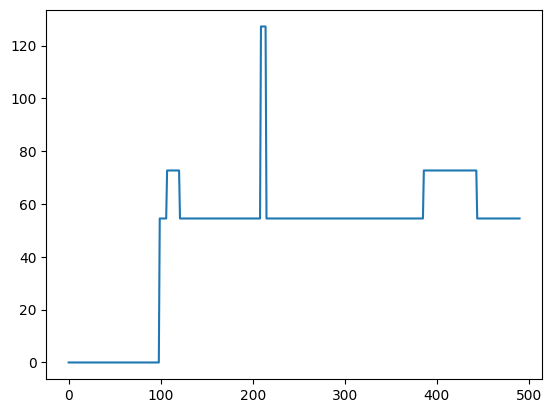

In [4]:
import matplotlib.pyplot as plt

plt.plot(bpm_all)

In [5]:
bpm_all[-1]

54.51924977366921

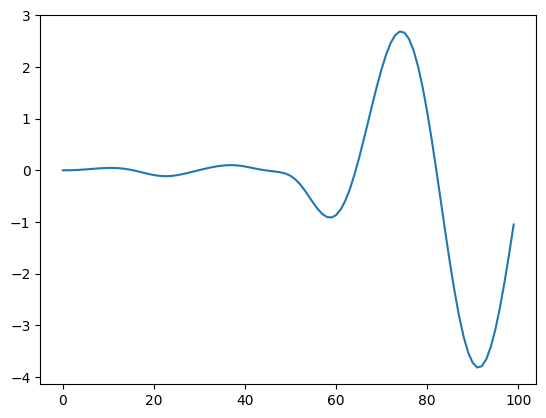

In [6]:
plt.plot(filtered_data)

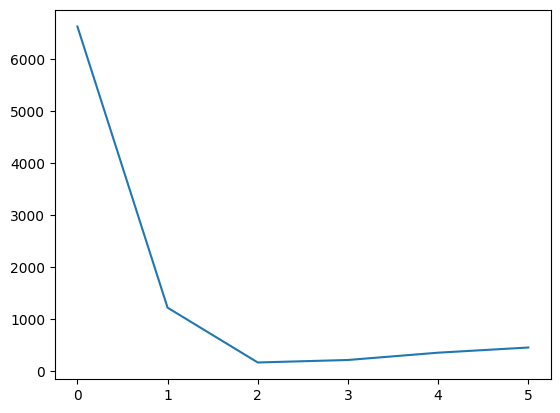

In [7]:
plt.plot(fft_of_interest)